## Data loading

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

import regex as re
from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_preprocessed"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
ftc_df = df[df[ftc_key]]
print(f'{len(df)=}')
print(f'{len(ftc_df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields
                          and field != ftc_key)]

df[independent_fields].describe()


Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'ln(1 + SharedExperiencePullReq

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),...,ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality)
count,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,...,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06
mean,5.030928e-01,4.031557e-01,9.875442e-02,5.957661e-02,4.194130e-01,1.184107e-01,2.986152e-01,1.690142e-01,1.422607e-01,5.350922e-02,...,1.635594e-02,3.940050e-02,8.727819e-02,1.451409e-01,1.149311e-02,1.972716e-02,9.570043e-03,1.759020e-02,8.877349e-02,7.431040e-02
std,4.710835e-01,4.523914e-01,2.910103e-01,2.291538e-01,2.256904e-01,7.150637e-02,1.869018e-01,1.843826e-01,1.856786e-01,1.295702e-01,...,7.410553e-02,1.069538e-01,1.245486e-01,1.814990e-01,5.408212e-02,8.011372e-02,5.264199e-02,8.248895e-02,1.049746e-01,9.861278e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.364295e-01,7.525668e-02,1.658837e-01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.842105e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.431563e-01,7.525668e-02,2.973435e-01,9.315576e-02,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.422832e-02,3.548693e-02
75%,1.000000e+00,9.393939e-01,0.000000e+00,0.000000e+00,5.859729e-01,1.505134e-01,4.383811e-01,3.094567e-01,2.738132e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.416667e-01,2.575606e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.365664e-01,1.118328e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [2]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

print(f'{len(train)=}, {len(test)=}')

train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]

test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


len(train)=979694, len(test)=244924


## Model Creation

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score


def calculate_metrics(predicted_labels, true_labels, sample_weights=None):
    return {
        "accuracy": accuracy_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "precision": precision_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "recall": recall_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "f1": f1_score(true_labels, predicted_labels, sample_weight=sample_weights)
    }


def create_model(
    train_predictors: pd.DataFrame,
    train_labels: pd.Series,
    test_predictors: pd.DataFrame,
    test_labels: pd.Series
):
    # Model creation and predictions.
    random_state = seed_counter.get_next()
    print(f'{random_state=}')
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=random_state)

    rf.fit(train_predictors, train_labels)

    predictions = rf.predict(test_predictors)
    predictions = [pred >= 0.5 for pred in predictions]

    # F1 scores.
    conf = confusion_matrix(test_labels, predictions)

    metrics = calculate_metrics(predictions, test_labels)

    print(f'{metrics=}\n')

    # Other metrics.
    print(f'Confusion matrix:\n{conf}\n')
    print("Classification report:")
    print(classification_report(test_labels, predictions))

    return rf, metrics


In [4]:
import regex as re
from python_proj.utils.util import subtract_dict

# Creates full model.
full_rf_model, full_rf_metrics = create_model(
    train_predictors,
    train_dependent,
    test_predictors,
    test_dependent
)

print("Performance metrics full model:")
print(json.dumps(full_rf_metrics, indent=4))


random_state=43
metrics={'accuracy': 0.8720337737420588, 'precision': 0.8968192397207138, 'recall': 0.9464803913440013, 'f1': 0.9209808439937676}

Confusion matrix:
[[ 30934  21014]
 [ 10328 182648]]

Classification report:
              precision    recall  f1-score   support

       False       0.75      0.60      0.66     51948
        True       0.90      0.95      0.92    192976

    accuracy                           0.87    244924
   macro avg       0.82      0.77      0.79    244924
weighted avg       0.87      0.87      0.87    244924

Performance metrics full model:
{
    "accuracy": 0.8720337737420588,
    "precision": 0.8968192397207138,
    "recall": 0.9464803913440013,
    "f1": 0.9209808439937676
}


In [5]:

# Creates control model.
control_fields = [field for field in independent_fields
                  if re.match(r'.*Control.*', field)]
print(control_fields)
control_rf_model, control_rf_metrics = create_model(
    train[control_fields],
    train_dependent,
    test[control_fields],
    test_dependent
)

print(json.dumps(control_rf_metrics, indent=4))
print("Comparison between control model and full model (negatives indicate control is better):")
diff = subtract_dict(full_rf_metrics, control_rf_metrics)
print(json.dumps(diff, indent=4))


['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)']
random_state=44
metrics={'accuracy': 0.7990437850108605, 'precision': 0.8508065106517972, 'recall': 0.9033558577232402, 'f1': 0.8762940752153335}

Confusion matrix:
[[ 21379  30569]
 [ 18650 174326]]

Classification report:
              precision    recall  f1-score   support

       False       0.53      0.41      0.46     51948
        True       0.85      0.90      0.88    192976

    accuracy                           0.80    244924
   macro avg       0.69      0.66      0.67    244924
weighted avg       0.78      0.80      0.79    244924

{
    "accuracy": 0.7990437850108605,
    "precision": 0.8508065106517972,
    "recall": 0.9033558577232402,
    "f1": 0.8762940752153335
}
Compar

In [6]:
# Creates measured information model.
non_control_fields = [field for field in independent_fields
                      if field not in control_fields]
non_control_rf_model, non_control_rf_metrics = create_model(
    train[non_control_fields],
    train_dependent,
    test[non_control_fields],
    test_dependent
)

print(json.dumps(non_control_rf_metrics, indent=4))
print("Comparison between non-control model and full model (negatives indicate non-control is better):")
diff = subtract_dict(full_rf_metrics, non_control_rf_metrics)
print(json.dumps(diff, indent=4))


random_state=45
metrics={'accuracy': 0.7909882249187503, 'precision': 0.8083762527839644, 'recall': 0.9630005803830528, 'f1': 0.8789398009762004}

Confusion matrix:
[[  7896  44052]
 [  7140 185836]]

Classification report:
              precision    recall  f1-score   support

       False       0.53      0.15      0.24     51948
        True       0.81      0.96      0.88    192976

    accuracy                           0.79    244924
   macro avg       0.67      0.56      0.56    244924
weighted avg       0.75      0.79      0.74    244924

{
    "accuracy": 0.7909882249187503,
    "precision": 0.8083762527839644,
    "recall": 0.9630005803830528,
    "f1": 0.8789398009762004
}
Comparison between non-control model and full model (negatives indicate non-control is better):
{
    "accuracy": 0.0810455488233085,
    "precision": 0.08844298693674935,
    "recall": -0.016520189039051503,
    "f1": 0.04204104301756717
}


### Non-control model without intra-project factors

In [7]:
# Creates measured information model.
non_control_fields_wo_intra = [field for field in non_control_fields
                               if not re.match(r'.*Intra.*', field)]
non_control_wo_intra_rf_model, non_control_wo_intra_rf_metrics = create_model(
    train[non_control_fields_wo_intra],
    train_dependent,
    test[non_control_fields_wo_intra],
    test_dependent
)

print(json.dumps(non_control_rf_metrics, indent=4))
print("Comparison between non-control model (without intra-project factors) and full model (negatives indicate non-control is better):")
diff = subtract_dict(full_rf_metrics, non_control_rf_metrics)
print(json.dumps(diff, indent=4))


random_state=46
metrics={'accuracy': 0.7808299717463376, 'precision': 0.7983703754476755, 'recall': 0.9657263079346654, 'f1': 0.8741099989681148}

Confusion matrix:
[[  4882  47066]
 [  6614 186362]]

Classification report:
              precision    recall  f1-score   support

       False       0.42      0.09      0.15     51948
        True       0.80      0.97      0.87    192976

    accuracy                           0.78    244924
   macro avg       0.61      0.53      0.51    244924
weighted avg       0.72      0.78      0.72    244924

{
    "accuracy": 0.7909882249187503,
    "precision": 0.8083762527839644,
    "recall": 0.9630005803830528,
    "f1": 0.8789398009762004
}
Comparison between non-control model (without intra-project factors) and full model (negatives indicate non-control is better):
{
    "accuracy": 0.0810455488233085,
    "precision": 0.08844298693674935,
    "recall": -0.016520189039051503,
    "f1": 0.04204104301756717
}


## Ablation Study

This is not executed.

In [8]:
from typing import Iterator


def ablation_study(
    train_predictors: pd.DataFrame,
    train_labels: pd.Series,
    test_predictors: pd.DataFrame,
    test_labels: pd.Series,
    evaluated_fields: Iterator[str],
):
    f1_differences_per_feature = {}

    for excluded_feature in evaluated_fields:
        print(f"Creating model without: {excluded_feature}.")
        _train_predictors = train_predictors.drop(excluded_feature, axis=1)
        _test_predictors = test_predictors.drop(excluded_feature, axis=1)

        _, excl_rf_metrics = create_model(
            _train_predictors, train_labels, _test_predictors, test_labels
        )

        diff = subtract_dict(full_rf_metrics, excl_rf_metrics)

        f1_differences_per_feature[excluded_feature] = {
            'Weighted metrics': excl_rf_metrics,
            'Weighted metrics difference': diff,
        }

    return f1_differences_per_feature


# f1_diffs_per_feature = ablation_study(
#     train_predictors, train_dependent,
#     test_predictors, test_dependent,
#     independent_fields
# )

print("Performance metrics ablation study vs. the full model (negatives suggest the ablation model is better):")
print(f1_diffs_per_feature)


Creating model without: ControlIntegratedBySameUser.
random_state=47
metrics={'accuracy': 0.8485979324198527, 'precision': 0.8795701123901907, 'recall': 0.9359972224525329, 'f1': 0.9069068013616782}

Confusion matrix:
[[ 27217  24731]
 [ 12351 180625]]

Classification report:
              precision    recall  f1-score   support

       False       0.69      0.52      0.59     51948
        True       0.88      0.94      0.91    192976

    accuracy                           0.85    244924
   macro avg       0.78      0.73      0.75    244924
weighted avg       0.84      0.85      0.84    244924

Creating model without: ControlPullRequestHasComments.
random_state=48
metrics={'accuracy': 0.8679222942627101, 'precision': 0.8921500173337304, 'recall': 0.9468275847773816, 'f1': 0.9186759482023938}

Confusion matrix:
[[ 29860  22088]
 [ 10261 182715]]

Classification report:
              precision    recall  f1-score   support

       False       0.74      0.57      0.65     51948
        

Outputs results in a csv format

In [18]:
print(json.dumps(f1_diffs_per_feature))

fields = ['accuracy', 'precision', 'recall', 'f1', 'accuracy_diff', 'precision_diff', 'recall_diff', 'f1_diff']
nested_dict= {}

for feature, scores in f1_diffs_per_feature.items():
    metrics = scores['Weighted metrics'].values()
    diff = scores['Weighted metrics difference'].values()
    vals = [*metrics, *diff]
    nested_dict[feature] = {}
    for field, value in zip(fields, vals):
        nested_dict[feature][field] = value
ablation_df = pd.DataFrame.from_dict(nested_dict)
output_path = f'{base_path}/coefs/{file_name}/ablation.csv'
ablation_df.to_csv(output_path)

{"ControlIntegratedBySameUser": {"Weighted metrics": {"accuracy": 0.8485979324198527, "precision": 0.8795701123901907, "recall": 0.9359972224525329, "f1": 0.9069068013616782}, "Weighted metrics difference": {"accuracy": 0.023435841322206108, "precision": 0.017249127330523084, "recall": 0.010483168891468386, "f1": 0.014074042632089334}}, "ControlPullRequestHasComments": {"Weighted metrics": {"accuracy": 0.8679222942627101, "precision": 0.8921500173337304, "recall": 0.9468275847773816, "f1": 0.9186759482023938}, "Weighted metrics difference": {"accuracy": 0.004111479479348756, "precision": 0.004669222386983307, "recall": -0.0003471934333802995, "f1": 0.002304895791373718}}, "ControlHasHashTagInDescription": {"Weighted metrics": {"accuracy": 0.8713396808805997, "precision": 0.8965693401972727, "recall": 0.9458170964264986, "f1": 0.9205350118017309}, "Weighted metrics difference": {"accuracy": 0.0006940928614591613, "precision": 0.00024989952344101063, "recall": 0.0006632949175027214, "f1"

Re-calculates performance scores, commparing them with an "all-true prediction" baseline.

In [57]:
vals = test_dependent.value_counts()
class_imbalance = vals[True] / vals[False]
print(f'{class_imbalance=}')
sample_weights = [class_imbalance if not merged else 1 for merged in test_dependent]

predictions = [True] * len(test_dependent)

metrics = calculate_metrics(predictions, test_dependent, sample_weights=sample_weights)
print(f'Weighted base metrics: {metrics}')

metrics = calculate_metrics(predictions, test_dependent)
print(f'Unweighted base metrics: {metrics}')

class_imbalance=3.7147917147917147
Weighted base metrics: {'accuracy': 0.5000000000000001, 'precision': 0.49999999999978456, 'recall': 1.0, 'f1': 0.6666666666664751}
Unweighted base metrics: {'accuracy': 0.78790155313485, 'precision': 0.78790155313485, 'recall': 1.0, 'f1': 0.8813701758392326}


In [58]:
def calculate_metrics_again(name: str, model: RandomForestRegressor, fields):
    predictions = model.predict(test_predictors[fields])
    predictions = [pred >= 0.5 for pred in predictions]
    metrics = calculate_metrics(predictions, test_dependent, sample_weights)
    print(f'{name}: {metrics}')

calculate_metrics_again("Full", full_rf_model, test_predictors.columns)
calculate_metrics_again("Control", control_rf_model, control_fields)
calculate_metrics_again("Non-control", non_control_rf_model, non_control_fields)
calculate_metrics_again("Non-control no intra", non_control_wo_intra_rf_model, non_control_fields_wo_intra)

Full: {'accuracy': 0.7709802434120487, 'precision': 0.7005774863569212, 'recall': 0.9464803913440013, 'f1': 0.8051724987096052}
Control: {'accuracy': 0.6574510096347008, 'precision': 0.6055436293502517, 'recall': 0.9033558577232402, 'f1': 0.7250600710872896}
Non-control: {'accuracy': 0.5574993661906027, 'precision': 0.5317500215841814, 'recall': 0.9630005803830528, 'f1': 0.6851652425900713}
Non-control no intra: {'accuracy': 0.5298524509566298, 'precision': 0.515948971505962, 'recall': 0.9657263079346654, 'f1': 0.672570437327198}


/tmp/ipykernel_630/2867122124.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


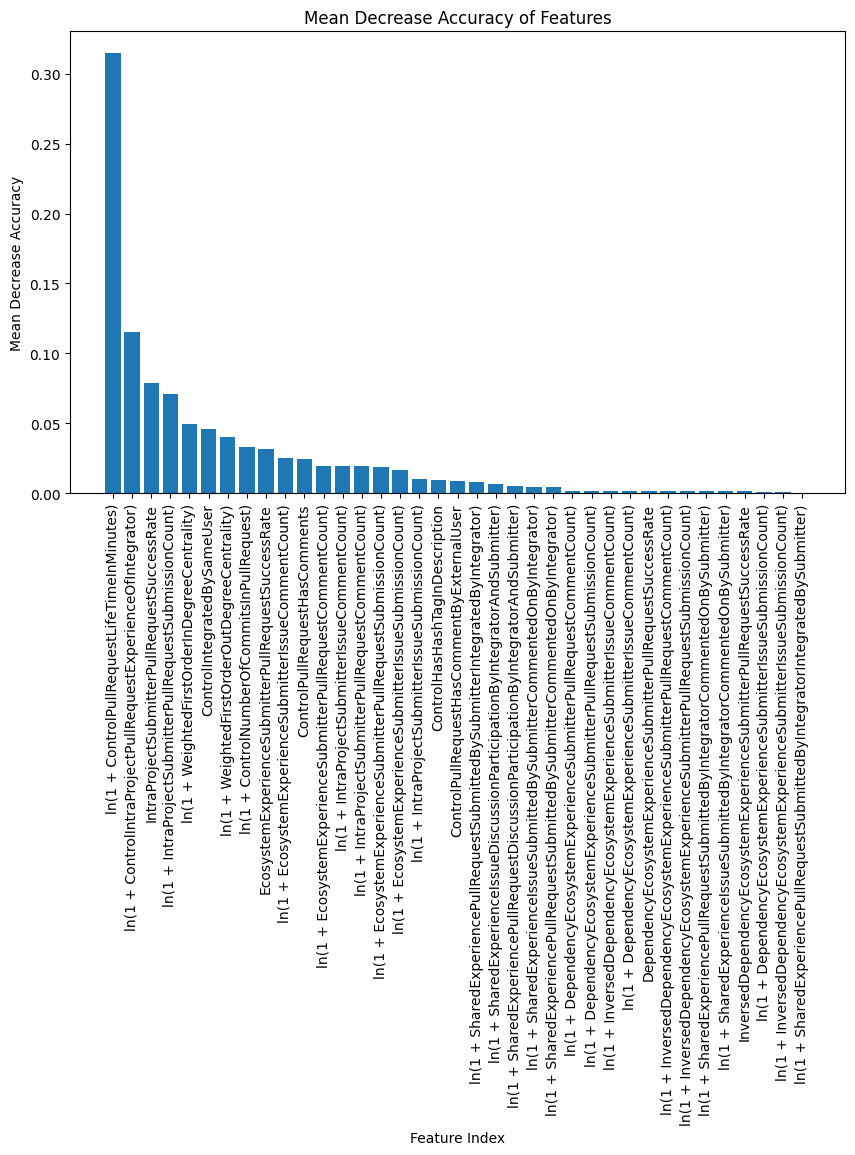

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.3145
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.1152
IntraProjectSubmitterPullRequestSuccessRate: 0.0786
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.0708
ln(1 + WeightedFirstOrderInDegreeCentrality): 0.0495
ControlIntegratedBySameUser: 0.0457
ln(1 + WeightedFirstOrderOutDegreeCentrality): 0.0405
ln(1 + ControlNumberOfCommitsInPullRequest): 0.0333
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.0318
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.0251
ControlPullRequestHasComments: 0.0247
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.0198
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.0194
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.0192
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount): 0.0186
ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount): 0.0169
ln(1 + IntraProjectSubmitterIssueSubmissionCount): 0.0101
ControlHasHashTagInDescription:

In [63]:
feature_importances = full_rf_model.feature_importances_    

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel('Feature Index')
plt.ylabel('Mean Decrease Accuracy')
plt.title('Mean Decrease Accuracy of Features')
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

for field, importance in zip(ordererd_columns, sorted_importances):
    print(f'{field}: {importance:.04f}')


## Partial Dependence Plots

In [64]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt


def create_partial_dependence_plots(
        rf_model: RandomForestRegressor,
        used_predictors: pd.DataFrame,
        used_labels: pd.Series,
        model_name: str = ""):

    # Collective partial dependence plot.
    PartialDependenceDisplay.from_estimator(
        rf_model, used_predictors, used_predictors.columns)

    fig = plt.gcf()
    axs = fig.axes

    lines = []
    for ax in axs:
        __lines = list([(line.get_xdata(), line.get_ydata())
                        for line in ax.lines])
        lines.extend(__lines)

    for (x, y), label in zip(lines, used_predictors.columns):
        plt.clf()
        plt.plot(x, y, linestyle='-', color='#e69d00')
        plt.xlabel(label)
        plt.ylabel('Partial Dependence')
        plt.tight_layout()
        output_path = f"{figure_base_path}/partial-dependence/{model_name}/{label}.png"
        safe_save_fig(output_path)


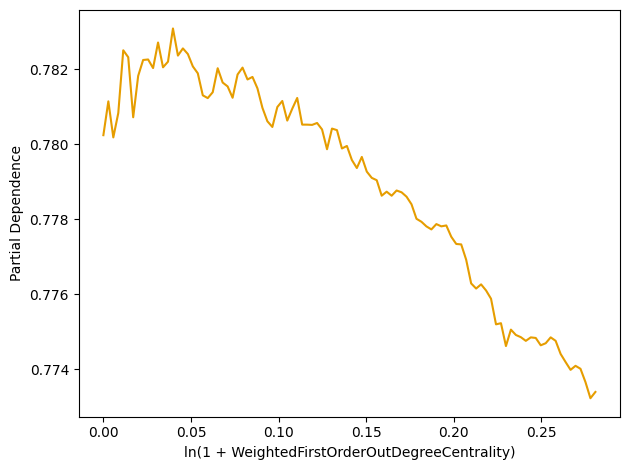

In [65]:
create_partial_dependence_plots(
    full_rf_model,
    test_predictors,
    test_dependent,
    model_name="full_model"
)
